In [1]:
import warnings

warnings.filterwarnings('ignore')
import requests
import torch
from PIL import Image
from argparse import Namespace

torch.set_grad_enabled(False)
%matplotlib inline

In [2]:
from models.deformable_detr import DeformableDETR
from models.deformable_transformer import DeformableTransformer
from models.backbone import Backbone, Joiner
from models.position_encoding import PositionEmbeddingSine
from models import build_model
from predict_utils import transform, rescale_bboxes, plot_results

In [3]:
args= Namespace(aux_loss=True,
                backbone='resnet50', 
                batch_size=2, 
                bbox_loss_coef=5, 
                cache_mode=True, 
                clip_max_norm=0.1, 
                cls_loss_coef=2, 
                coco_panoptic_path=None, 
                coco_path='D:/dataset/coco2017',
                dataset_file='coco', 
                dec_layers=6, 
                dec_n_points=4, 
                device='cuda', 
                dice_loss_coef=1, 
                dilation=False, 
                dim_feedforward=1024, 
                dist_backend='nccl', 
                dist_url='env://', 
                distributed=True, 
                dropout=0.1, 
                enc_layers=6, enc_n_points=4, 
                epochs=50, 
                eval=False, 
                focal_alpha=0.25, 
                frozen_weights=None, 
                giou_loss_coef=2, 
                gpu=0, hidden_dim=256, lr=0.0002, lr_backbone=2e-05, 
                lr_backbone_names=['backbone.0'], 
                lr_drop=40, lr_drop_epochs=None, lr_linear_proj_mult=0.1, 
                lr_linear_proj_names=['reference_points', 'sampling_offsets'], 
                mask_loss_coef=1, 
                masks=False, nheads=8, num_feature_levels=4, num_queries=300, num_workers=4, 
                output_dir='exps/r50_deformable_detr', 
                position_embedding='sine', position_embedding_scale=6.283185307179586, 
                rank=0, remove_difficult=False, resume='', 
                seed=42, set_cost_bbox=5, set_cost_class=2, set_cost_giou=2, 
                sgd=False, start_epoch=0, 
                two_stage=False, weight_decay=0.0001, with_box_refine=False, world_size=16)
device = torch.device(args.device)

In [4]:
model, _ , _ = build_model(args)
model.load_state_dict(torch.load("./r50_deformable_detr-checkpoint.pth")['model']);
model.to(device)
model.eval();

In [5]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
im = Image.open(requests.get(url, stream=True).raw)
img = transform(im).unsqueeze(0)

In [6]:
img=img.to(device)
outputs = model(img)
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.5
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'].to(torch.device('cpu'))[0, keep], im.size)

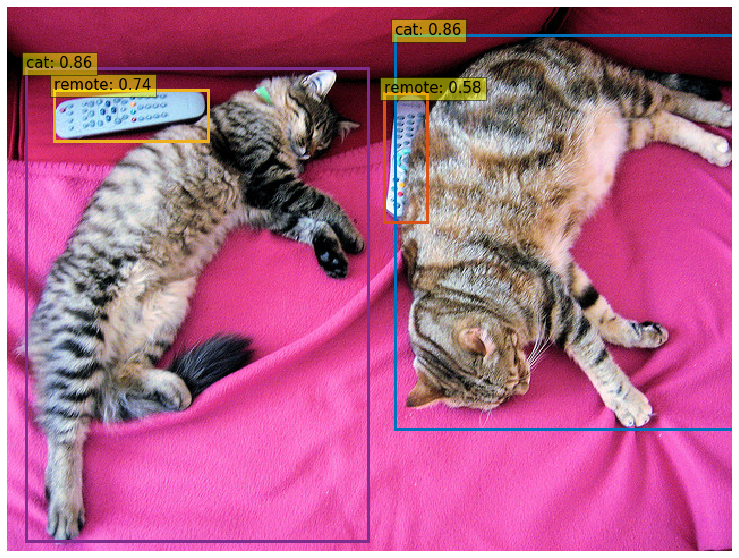

In [7]:
plot_results(im, probas[keep], bboxes_scaled)

In [10]:
model.transformer.decoder.layers[0].cross_attn

MSDeformAttn(
  (sampling_offsets): Linear(in_features=256, out_features=256, bias=True)
  (attention_weights): Linear(in_features=256, out_features=128, bias=True)
  (value_proj): Linear(in_features=256, out_features=256, bias=True)
  (output_proj): Linear(in_features=256, out_features=256, bias=True)
)